In [1]:
import pandas as pd
import names
import numpy as np
from sklearn import datasets
from collections import defaultdict
from scipy.stats import truncnorm
# import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

import matplotlib.pyplot as plt
# %matplotlib inline

# Where We Start Building the Dataset

In [2]:
employeeData = pd.DataFrame()
numPpl = 10000

In [3]:
def discretize(vector, range):
    newRange = range
    vals = [range]
    x = True
    while(x):
        range -= 1
        if abs(range) <= newRange:
            vals.append(range)
        else:
            x=False
    roundedVals = []
    for x in vector:
        newVal = int(x)
        if abs(newVal) > newRange:
            # if greater than the newRange:
            if newVal < 0:
                newVal = -1*newRange
            else:
                newVal = 1*newRange
        roundedVals.append(newVal)
    return roundedVals


# featuresCorrelatingToPerformance generates the "Job Performance" feature along with all
# other features we desire to correlate with "Job Performance" is systematized way
# the method uses the cholesky decomposition of a covariance matrix to generate a 
# correlation matrix which is multiplied against the set number of features to correlate with job
# performance that are initially random normal distributions with stddev = 1 and mean = 0
def featuresCorrelatingToPerformance(numPpl):
    m = np.array([[1.3, .1, -1.1, 1.5, 1.5, 1.61],
             [1.0, -1., .3, 1.5, 1.01, .993],
             [1.1, .8, -1.1, 1.01, -1, .909],
             [1.1, 0.2, -1.001, 1.1, .98, -1.5],
             [1.05, 1.02, -1.01, 1.02, 1.03, 1.001],
             [1.03 , .998, 1.01,.9, 1.01, 1.3],
             ])
    res = np.matmul(m, m.T)
    method = cholesky
    r = res
    # Generate samples from three independent normally distributed random
    # variables (with mean 0 and std. dev. 1).
    x = norm.rvs(size=(6, numPpl))
    print(np.linalg.eigvals(r))

    # We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
    # the Cholesky decomposition, or the we can construct `c` from the
    # eigenvectors and eigenvalues.

    if method == 'cholesky':
        # Compute the Cholesky decomposition.
        c = cholesky(r, lower=True)
    else:
        # Compute the eigenvalues and eigenvectors.
        evals, evecs = eigh(r)
        # Construct c, so c*c^T = r.
        c = np.dot(evecs, np.diag(np.sqrt(evals)))

    # Convert the data to correlated random variables. 
    y = np.dot(c, x)
    
    # y[0] is the job performance, and we want to bucket y-vals from -2 to +2
    return discretize(y[0], 2), y[1:]


jobPerf, correlatedFeatures = featuresCorrelatingToPerformance(numPpl)


[2.61133594e+01 3.47938463e-03 1.44985390e+00 2.53764659e+00
 5.14437724e+00 6.54171944e+00]


In [4]:
# Replaces all neg values with zero
def negsToZero(array):
    adjustedArray = array
    for x in range(len(adjustedArray)):
        if adjustedArray[x] < 0:
            adjustedArray[x] = 0
    return adjustedArray

# Replaces all negative values with their abs value
def negsToOpp(array):
    adjustedArray = array
    for x in range(len(adjustedArray)):
        if adjustedArray[x] < 0:
            adjustedArray[x] = -1 * adjustedArray[x]
    return adjustedArray

# Replaces all values under the mini values w/ mini and all values above the maxi value w/ maxi
def imposeBoundaries(array, mini, maxi):
    adjustedArray = array
    for x in range(len(adjustedArray)):
        if adjustedArray[x] < mini:
            adjustedArray[x] = mini
        if adjustedArray[x] > maxi:
            adjustedArray[x] = maxi
    return adjustedArray

# Transform features, takes the raw correlated features and fits them into a proper range and bounds.
def transformFeatures(correlatedFeatures):
    leadershipCapability = correlatedFeatures[0] * .3 # LeadershipCapability
    gpa = correlatedFeatures[1] * .2 + 3 # GPA
    # techApt = imposeBoundaries(y[3] / 3 + 2, 0, 4) # Technical Aptitude
    techApt = correlatedFeatures[2] / 3 + 2
    # softSkills = imposeBoundaries(y[4] / 3 + 3, 0, 5) # Soft Skills
    softSkills = correlatedFeatures[3] / 3 + 3
    # yearsOfExperience = negsToZero(y[5] + 4) # Years of Experience
    yearsOfExperience = correlatedFeatures[4] + 4
    return leadershipCapability, gpa, techApt, softSkills, yearsOfExperience

leadershipCapability, gpa, techApt, softSkills, yearsOfExp = transformFeatures(correlatedFeatures)

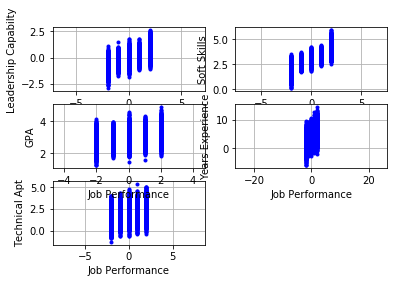

In [5]:
# Plot various projections of the samples.
subplot(3,2,5)
plot(jobPerf, techApt, 'b.')
xlabel("Job Performance")
ylabel("Technical Apt")
axis('equal')
grid(True)

subplot(3,2,1)
plot(jobPerf, leadershipCapability, 'b.')
ylabel('Leadership Capabilty')
axis('equal')
grid(True)

subplot(3,2,2) 
plot(jobPerf, softSkills, 'b.')
ylabel("Soft Skills")
axis('equal')
grid(True)

subplot(3,2,3)
plot(jobPerf, gpa, 'b.')
xlabel('Job Performance')
ylabel('GPA')
axis('equal')
grid(True)

subplot(3,2,4)
plot(jobPerf, yearsOfExp, 'b.')
xlabel('Job Performance')
ylabel('Years Experience')
axis('equal')
grid(True)

show()

In [6]:
employeeData["GPA"] = gpa
employeeData["Leadership Capability"] = leadershipCapability
employeeData["Technical Aptitude"] = techApt
employeeData["Years of Experience"] = yearsOfExp
employeeData["Soft Skills"] = softSkills
employeeData["Job Performance"] = jobPerf
# correlated_vars.to_csv("correlated_vars.csv")
employeeData["Job Performance"].value_counts()

-2    2736
 2    2625
 0    2428
 1    1144
-1    1067
Name: Job Performance, dtype: int64

In [7]:
def genFeaturesCorrelatingToTenure(numPpl):
# Make the Matrix
    m = np.array(([
        [  1.20, 1.00, 1.10],
        [ 1.00,  .90, 1.30],
        [ -1.20,  -1.50,  -1.20]
    ]))
    res = np.matmul(m, m.T)
    print(res)
    method = 'cholesky'
    num_samples = numPpl
    r = res
    # Generate samples from three independent normally distributed random
    # variables (with mean 0 and std. dev. 1).
    x = norm.rvs(size=(3, num_samples))
    print(np.linalg.eigvals(r))

    # We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
    # the Cholesky decomposition, or the we can construct `c` from the
    # eigenvectors and eigenvalues.
    if method == 'cholesky':
        # Compute the Cholesky decomposition.
        c = cholesky(r, lower=True)
    else:
        # Compute the eigenvalues and eigenvectors.
        evals, evecs = eigh(r)
        # Construct c, so c*c^T = r.
        c = np.dot(evecs, np.diag(np.sqrt(evals)))
    # Convert the data to correlated random variables. 
    y = np.dot(c, x)
    return y[0], y[1:]


jobTenure, correlatesToTenure = genFeaturesCorrelatingToTenure(10000)
print(len(jobTenure))

[[ 3.65  3.53 -4.26]
 [ 3.53  3.5  -4.11]
 [-4.26 -4.11  5.13]]
[12.11911086  0.03140689  0.12948225]
10000


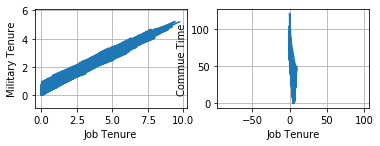

In [8]:
def transformTenureCorrelates(jobTenure, correlatesToTenure):
    jobTenure = negsToZero(jobTenure + 3)
    militaryTenure = negsToZero(correlatesToTenure[0] * .5 + 2) # LeadershipCapability
    commuteTime = negsToOpp(correlatesToTenure[1] * 10 + 30) # GPA
    return jobTenure, militaryTenure, commuteTime

jobTenure, militaryTenure, commuteTime = transformTenureCorrelates(jobTenure, correlatesToTenure)
employeeData["Military Tenure"] = militaryTenure
employeeData["Avg Commute Time"] = commuteTime
employeeData["Job Tenure"] = jobTenure


subplot(2, 2, 1)
plot(jobTenure, militaryTenure)
xlabel('Job Tenure')
ylabel('Military Tenure')
axis('equal')
grid(True)


subplot(2, 2, 2)
plot(jobTenure, commuteTime)
xlabel('Job Tenure')
ylabel('Commue Time')
axis('equal')
grid(True)


In [9]:
# We now are moving into features that will correlate but not through a correlation matrix but rather
# through far more manual methods.
import heapq
import math
import random

In [10]:
def binaryArrayGenerator(n, p): #where n is num values and p is the probability of success (1)
    x = np.zeros(n)
    num = int(p*100)
    x[:num] = 1
    np.random.shuffle(x)
    return x

def getTopIndxs(array, num):
    leftover = []
    top = heapq.nlargest(num, range(len(array)), array.__getitem__)
    for x in range(len(array)):
        if x not in top:
            leftover.append(x)
    return top, leftover   

In [11]:
percentileToNum = math.floor(.20 * numPpl)
numOfReferrals = math.floor(.25 * numPpl)
top, leftover = getTopIndxs(jobPerf, percentileToNum)

# Manual Generation of features w/ job Performance...
def genEmployeeReferrals(numPpl, top, leftover, cutoff, numOfReferrals):
    indxs = top
    np.random.shuffle(indxs)
    np.random.shuffle(leftover)
    
    numOfTop = math.floor(len(indxs) * cutoff)
#     print(numOfTop)
    array = np.zeros(numPpl)
#     print(numOfReferrals)
    for x in range(numOfReferrals):
        if x < numOfTop:
            array[top[x]] = 1
        elif x >= numOfTop: 
            array[leftover[x]] = 1
    return array

def genHireVueScores(numPpl, jobPerf):
    leftover = []
    one_third = math.floor(numPpl * .33)
    top = heapq.nlargest(one_third, range(len(jobPerf)), jobPerf.__getitem__)
    hirevueScores = np.zeros(numPpl)
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    for x in top:
        hirevueScores[x] = 2
            
    last = []
    second = heapq.nlargest(one_third, range(len(leftover)), leftover.__getitem__)
    for x in range(len(leftover)):
        if x not in second:
            last.append(x)
    for x in second:
        hirevueScores[x] = 1
    
    # Now we "inject" randomness
    percentileOfRandomness = .1
    np.random.shuffle(top)
    np.random.shuffle(second)
    np.random.shuffle(last)
    
    for x in range(math.floor(one_third*percentileOfRandomness)):
        scores = [0, 1, 2]
        hirevueScores[top[x]] = random.choice(scores)
        hirevueScores[second[x]] = random.choice(scores)
        hirevueScores[last[x]] = random.choice(scores)
    return hirevueScores
    
def genCulturalFit(numPpl, jobPerf):
    leftover = []
    one_fourth = math.floor(numPpl * .25)
    top = heapq.nlargest(one_fourth, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    culturalFitScores = np.zeros(numPpl)
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    for x in top:
        culturalFitScores[x] = 2 
            
    last = []
    second = heapq.nlargest(one_fourth, range(len(leftover)), leftover.__getitem__)
    random.shuffle(second)
    for x in range(len(leftover)):
        if x not in second:
            last.append(x)
    for x in second:
        culturalFitScores[x] = 1
    
    # Now we "inject" randomness
    percentileOfRandomness = .25
    np.random.shuffle(top)
    np.random.shuffle(second)
    np.random.shuffle(last)
    
    for x in range(math.floor(one_fourth*percentileOfRandomness)):
        scores = [0, 1, 2]
        culturalFitScores[top[x]] = random.choice(scores)
        culturalFitScores[second[x]] = random.choice(scores)
        culturalFitScores[last[x]] = random.choice(scores)
    return culturalFitScores
    

employeeReferrals = genEmployeeReferrals(numPpl, top, leftover, .85, numOfReferrals) 
hirevueScores = genHireVueScores(numPpl, jobPerf)
culturalFit = genCulturalFit(numPpl, jobPerf)

employeeData["Employee Referrals"] = employeeReferrals
employeeData["HireVue Score"] = hirevueScores
employeeData["Cultural Fit"] = culturalFit

In [12]:
# We now want to sanity check our manipulations and analysis by hand if the relations we desire are holding
print(employeeData.groupby(['Employee Referrals', 'Job Performance']).size())
print(employeeData.groupby(['Cultural Fit', 'Job Performance']).size())
print(employeeData.groupby(['HireVue Score', 'Job Performance']).size())

Employee Referrals  Job Performance
0.0                 -2                 2482
                    -1                  960
                     0                 2170
                     1                 1032
                     2                  856
1.0                 -2                  254
                    -1                  107
                     0                  258
                     1                  112
                     2                 1769
dtype: int64
Cultural Fit  Job Performance
0.0           -2                 1948
              -1                  789
               0                 1782
               1                  829
               2                  414
1.0           -2                  669
              -1                  236
               0                  526
               1                  263
               2                  618
2.0           -2                  119
              -1                   42
               0         

In [13]:
def generateFields(probs, labels, ppl):
    fields = []
    for x in range(len(probs)):
        fields += [labels[x] for y in range(int(ppl*probs[x]))]
    return fields

# Education Stuff Generated ... 
def genEducation(numPpl, jobPerf):
    leftover = []
    one_half = math.floor(numPpl * .5)
    top = heapq.nlargest(one_half, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    education = np.zeros(numPpl)

    tophalf_labels = generateFields([.3, .67, .03], [2, 1, 0], len(top))
    random.shuffle(tophalf_labels)
    
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    for x in top:
        education[x] = tophalf_labels.pop()
    
    bottomhalf_labels = generateFields([.1, .83, .07], [2, 1, 0], len(leftover))
#     print(len(bottomhalf_labels))
#     print(len(leftover))
    random.shuffle(bottomhalf_labels)
    
    for x in leftover:
        education[x] = bottomhalf_labels.pop()
    return education

def genEducationalPrestige(numPpl, jobPerf, education):
    leftover = []
    one_third = math.floor(numPpl * .33)
    top_third = heapq.nlargest(one_third, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top_third)
    
    educationalPrestige = np.zeros(numPpl)
    topthird_labels = generateFields([.45, .45, .1], [3, 2, 1], len(top_third))
    random.shuffle(topthird_labels)

    
    for x in range(len(jobPerf)):
        if x not in top_third:
            leftover.append(x)
    for x in top:
        if education[x] == 0:
            educationalPrestige[x] = 0
        else:
            educationalPrestige[x] = topthird_labels.pop()
    
    second_third = heapq.nlargest(one_third, range(len(leftover)), leftover.__getitem__)
    random.shuffle(second_third)
    secondthird_labels = generateFields([.2, .6, .2], [3, 2, 1], len(second_third))
    random.shuffle(secondthird_labels)

    last = []
    for x in range(len(leftover)):
        if x not in second_third:
            last.append(x)
    for x in second_third:
        if education[x] == 0:
            educationalPrestige[x] = 0
        else:
            educationalPrestige[x] = secondthird_labels.pop()
    
    lastthird_labels = generateFields([.05, .15, .8], [3, 2, 1], len(last))
    random.shuffle(lastthird_labels)
    
    for x in last:
        if education[x] == 0:
            educationalPrestige[x] = 0
        else:
            educationalPrestige[x] = lastthird_labels.pop()
    return educationalPrestige


def genDegreeTypes(numPpl, jobPerf, education, skew):
    labels = ["Humanities", "Sciences", "Quantitative", "Engineering"]
    degree = []
    fields = []
    if skew == "standard":
        standardProbs = [.25, .25, .25, .25]
        standardFields = generateFields(degreeProbs, labels, numPpl)
        for x in range(len(jobPerf)):
            if education[x] == 0:
                degree.append("None")
            else:
                degree.append(random.choice(standardFields))
    elif skew == "biased": 
        poorPerf = generateFields([.5, .3, .1, .1], labels, numPpl)
        goodPerf = generateFields([.1, .1, .3, .5], labels, numPpl)
        for x in range(len(jobPerf)):
            if education[x] == 0:
                degree.append("None")
            else:
                if jobPerf[x] == -2 or jobPerf[x] == -1 or jobPerf[x] == 0: 
                    degree.append(random.choice(poorPerf))
                else:
                    degree.append(random.choice(goodPerf))
    return degree  
    
def genLinkedinScore(numPpl, jobPerf):
    # Percentage of students with low-tier - (0), mid-tier(1), high tier university(2)
    labels = ['None', 'Ok', "Very Good"]
    worst = generateFields([.4, .40, .10], labels, numPpl)
    med = generateFields([.20, .50, .30], labels, numPpl)
    high = generateFields([.10, .40, .50], labels, numPpl)
    linkedinScore = []
    
    for x in range(len(jobPerf)):
        if jobPerf[x] == -1 or jobPerf[x] == -2:
            linkedinScore.append(random.choice(worst))
        if jobPerf[x] == 0 or jobPerf[x] == 1:
            linkedinScore.append(random.choice(med))
        if jobPerf[x] == 2:
            linkedinScore.append(random.choice(high))
    return linkedinScore


def responsibleSocMediaUse(numPpl, jobPerf):
    # Percentage of students with low-tier - (0), mid-tier(1), high tier university(2)
    labels = ["Bad", "Good"]
    worst = generateFields([.5, .5], labels, numPpl)
    med = generateFields([.2, .8], labels, numPpl)
    high = generateFields([.05, .95], labels, numPpl)
    socialmediaScore = []
    
    for x in range(len(jobPerf)):
        if jobPerf[x] == -1 or jobPerf[x] == -2:
            socialmediaScore.append(random.choice(worst))
        if jobPerf[x] == 0 or jobPerf[x] == 1:
            socialmediaScore.append(random.choice(med))
        if jobPerf[x] == 2:
            socialmediaScore.append(random.choice(high))
    return socialmediaScore
    
     
education = genEducation(numPpl, jobPerf)
degrees = genDegreeTypes(numPpl, jobPerf, education, "biased")   
linkedinScore = genLinkedinScore(numPpl, jobPerf)
socialmediaScore = responsibleSocMediaUse(numPpl, jobPerf)
educationalPrestige = genEducationalPrestige(numPpl, jobPerf, education)    

In [14]:
# Assign & Sanity Check
print(len(education))
print(len(educationalPrestige))
employeeData["Education"] = education
employeeData["Educational Prestige"] = educationalPrestige
employeeData["Degree"] = degrees
employeeData["LinkedIn Score"] = linkedinScore
employeeData["Responsible Social Media Use"] =  socialmediaScore

print(employeeData.groupby(["Education", "Job Performance"]).size())
print(employeeData.groupby(["Educational Prestige", "Job Performance"]).size())
print(employeeData.groupby(["Degree", "Job Performance"]).size())
print(employeeData.groupby(["LinkedIn Score", "Job Performance"]).size())
print(employeeData.groupby(["Degree", "Job Performance"]).size())

10000
10000
Education  Job Performance
0.0        -2                  201
           -1                   77
            0                  108
            1                   30
            2                   84
1.0        -2                 2263
           -1                  893
            0                 1827
            1                  790
            2                 1727
2.0        -2                  272
           -1                   97
            0                  493
            1                  324
            2                  814
dtype: int64
Educational Prestige  Job Performance
0.0                   -2                 1026
                      -1                  374
                       0                  880
                       1                  441
                       2                  688
1.0                   -2                  862
                      -1                  351
                       0                  790
                 

In [15]:
def genArrestRecords(numPpl, jobPerf):
    one_fifth = math.floor(numPpl * .8)
    top = heapq.nlargest(one_fifth, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    leftover = []
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    arrestRecords = np.zeros(numPpl)
    for x in range(math.floor(numPpl * .2)):
        if x < math.floor(numPpl * .2) * .6:
            arrestRecords[leftover[x]] = 1
        else: 
            arrestRecords[top[x]] = 1
    return arrestRecords

def genCriminalRecords(numPpl, jobPerf):
    one_tenth = math.floor(numPpl * .9)
    top = heapq.nlargest(one_tenth, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    leftover = []
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    criminalRecords = np.zeros(numPpl)
    print(criminalRecords.shape)
    for x in range(math.floor(numPpl * .1)):
        if x < math.floor(numPpl * .1) * .75:
            criminalRecords[leftover[x]] = 1
        else: 
            criminalRecords[top[x]] = 1
    return criminalRecords


arrestRecords = genArrestRecords(numPpl, jobPerf)
criminalRecords = genCriminalRecords(numPpl, jobPerf)

(10000,)


In [16]:
# Assign & Sanity Check
print(len(arrestRecords))
print(len(criminalRecords))
employeeData["Arrest Record"] = arrestRecords
employeeData["Criminal Record"] = criminalRecords

print(employeeData.groupby(["Arrest Record", "Job Performance"]).size())
print(employeeData.groupby(["Criminal Record", "Job Performance"]).size())

10000
10000
Arrest Record  Job Performance
0.0            -2                 1459
               -1                  952
                0                 2191
                1                 1026
                2                 2372
1.0            -2                 1277
               -1                  115
                0                  237
                1                  118
                2                  253
dtype: int64
Criminal Record  Job Performance
0.0              -2                 1939
                 -1                 1038
                  0                 2357
                  1                 1107
                  2                 2559
1.0              -2                  797
                 -1                   29
                  0                   71
                  1                   37
                  2                   66
dtype: int64


# Inject the Bias - .....

In [17]:
import names

In [32]:
# Assign Gender to the Individuals ...
#     sexValues = {"Male": 0, "Female": 1}
#     maleRatio = .6
#     femaleRatio = .4

#     maleNames = generateNames('male', int(maleRatio*numPpl))
#     femaleNames = generateNames('female', int(femaleRatio*numPpl))
#     nameFields = maleNames + femaleNames
#     nameToSex = {name: 0 for name in maleNames}
#     nameToSex2 = {name: 1 for name in femaleNames}
#     nameToSex.update(nameToSex2)
#     random.shuffle(nameFields)
    
#     sexFields = [nameToSex[name] for name in nameFields]
#     assert(len(sexFields) == numPpl)


# def makeTables(features, params, probabilityTable):
#     # Create the table...
#     valuesToProbs = {}
#     for x in range(len(probabilityTable["Tech Aptitude"])):
#         valuesToProbs.update({(probabilityTable["Tech Aptitude"][x], probabilityTable["Leadership Capability"][x], probabilityTable["Referral"][x]): probabilityTable["Probability"][x]})
    
#     print(valuesToProbs)
#     indxsToPercentiles = {}
#     indxsToValues = {}
#     valuesToIndxs = {}
#     for x in range(0, params[0]):
#         x_param_size = 1 / params[0]
#         print("Outer loop iteration: ", x)
#         print("Top Percentile", x*x_param_size)
#         print("Bottom Percentile", x*x_param_size + x_param_size)
        
#         x_indxs = indexsOfSpecificPercentile(features[0], x*x_param_size, x*x_param_size + x_param_size)
        
#         print("Num of x-indxs", len(x_indxs))
#         for y in range(0, params[1]):
#             print("Second loop iteration: ", y)
          
#             y_param_size = 1/params[1]
#             print("Top Percentile", y*y_param_size)
#             print("Bottom Percentile", y*y_param_size + y_param_size)
#             y_indxs = indexsOfSpecificPercentile(features[1], y*y_param_size, y*y_param_size + y_param_size)
#             yindxs_intersect = [indx for indx in y_indxs if indx in x_indxs]
#             print("Num of y-indxs", len(yindxs_intersect))
#             for z in range(params[2]):
#                 print("Third loop iteration: ", z)
#                 z_param_size = 1 / params[2]
#                 print("Top Percentile", z*z_param_size)
#                 print("Bottom Percentile", z*z_param_size + z_param_size)
#                 z_indxs = indexsOfSpecificPercentile(features[2], z*z_param_size, z*z_param_size + z_param_size)
#                 print("Len of z_indxs", len(z_indxs))
#                 zindxs_intersect = [indx for indx in z_indxs if indx in yindxs_intersect]
#                 print("Num of z-indxs", len(zindxs_intersect))
                
#                 for indx in zindxs_intersect:
#                     value = (x, y, z)
#                     indxsToPercentiles.update({indx : valuesToProbs[value]})   
#                     indxsToValues.update({indx: value})
#                 valuesToIndxs.update({value:zindxs_intersect})
                
#     return indxsToPercentiles, indxsToValues, valuesToProbs, valuesToIndxs

# probs = pd.read_csv("probs.csv")
# features = [tuple(techApt),  tuple(leadershipCapability), tuple(employeeReferrals)]
# indxsToPercentiles, indxsToValues, valuesToProbs, valuesToIndxs = makeTables(features, [3, 3, 2], probs)

# indxsToPercentiles = makeTables(features, [3, 3, 2], probs)


# Generation will be like the following
# def genGender(numPpl, valuesToIndxs, valuesToProbs):
#     sex = np.zeros(numPpl)
#     percentOfFemales = .42
#     numFemales = math.floor(percentOfFemales * numPpl)
#     print(numFemales)
#     indxs = [x for x in range(numPpl)]
#     total = 0
#     for value in valuesToIndxs.keys():
        
#         prob = valuesToProbs[value] / 100
        
#         num = math.floor(numFemales * prob)
#         print(num)
#         total += num
#         for x in range(num):
#             samples = valuesToIndxs[value]
#             random.shuffle(samples)
#             sex[samples.pop()] = 1
#     print(sum(sex))
#     print(total)
#     return sex

# gender = genGender(numPpl, valuesToIndxs, valuesToProbs)

In [18]:
def indexsOfSpecificPercentile(array, x, y):
#     print("In helper")
    arraySize = len(array)
    topPercent = math.floor(x*arraySize)
    bottomPercent = math.floor(y * arraySize)
    
    top_bound = heapq.nlargest(topPercent, range(arraySize), array.__getitem__)
#     print(len(top_bound))
    
    minus_top = []
    for x in range(arraySize):
        if x not in top_bound:
            minus_top.append(x)
#     print(len(minus_top))
    lower_bound = heapq.nlargest(bottomPercent, range(arraySize), array.__getitem__)
#     print(len(lower_bound))
    array = [elem for elem in minus_top if elem in lower_bound]
    return array

def genGender(employeeData, numPpl):
    intermediateScore = employeeData["Technical Aptitude"] + employeeData["Leadership Capability"] + employeeData["Employee Referrals"]
    bottom_quartile = indexsOfSpecificPercentile(intermediateScore, .75, 1.0)
    half_quartile = indexsOfSpecificPercentile(intermediateScore, .5, .75)
    random.shuffle(bottom_quartile)
    random.shuffle(half_quartile)

    gender = np.zeros(numPpl)
    numFemales = math.floor(numPpl * .42)
    for x in range(numFemales):
        if x < (numFemales / 2):
            gender[bottom_quartile.pop()] = 1
        else: 
            gender[half_quartile.pop()] = 1
    return gender

gender = genGender(employeeData, numPpl)


In [521]:
# proxyForDegree = {"Quantitative": 3, "Engineering": 2, "Sciences": 1, "Humanities":0, "None": -1}
# substituteDegree = [proxyForDegree[elem] for elem in list(employeeData["Degree"])]

In [19]:
# Race Bias Injection
raceIndxs = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4 }

def genRace(employeeData, numPpl):
    arrestAndCrime = -1*employeeData["Criminal Record"] - employeeData["Arrest Record"]
    intermediateScore = employeeData["Education"] + employeeData["Educational Prestige"]
    bottom_half = indexsOfSpecificPercentile(intermediateScore, .5, 1.0)
    top_half = indexsOfSpecificPercentile(intermediateScore, 0, .5)

    random.shuffle(bottom_half)
    random.shuffle(top_half)

    race = np.zeros(numPpl)

    numBlacks = math.floor(numPpl * .00)
    numWhites = math.floor(numPpl * .34)
    numAsian = math.floor(numPpl * .16)
    numHispanic = math.floor(numPpl * .00)
    numOther = math.floor(numPpl * .00)

    numBlacks1 = math.floor(numPpl * .30)
    numWhites1 = math.floor(numPpl * .04)
    numAsian1 = math.floor(numPpl * .00)
    numHispanic1 = math.floor(numPpl * .10)
    numOther1 = math.floor(numPpl * .06)

    # Bottom half
    numPerRace = [(1, numBlacks1), (0, numWhites1), (2, numAsian1), (3, numHispanic1), (4, numOther1)]
    for x, y in numPerRace:
        for z in range(y):
            race[bottom_half.pop()] = x
    # Top half
    numPerRace = [(1, numBlacks), (0, numWhites), (2, numAsian), (3, numHispanic), (4, numOther)]
    for x, y in numPerRace:
        for z in range(y):
            race[top_half.pop()] = x
    return race

race = genRace(employeeData, numPpl)

In [20]:
def generateNames(gender):
    nameList = []
    print("This takes a while - .get_full_name is slow when generating 10000 names")
    for x in range(10000):
        if gender[x] == 0:
            name = names.get_full_name(gender = "male")
            nameList.append(name)
        else:
            name = names.get_full_name(gender = "female")
            nameList.append(name)
    return nameList

theNames = generateNames(gender)

This takes a while - .get_full_name is slow with a certain amount of names


In [21]:
employeeData["Names"] = theNames
employeeData["Gender"] = gender
employeeData["Race"] = race

In [529]:
# Sanity Check by grouping
# employeeData.groupby(["Gender", "Employee Referrals"]).size()
# employeeData.groupby(["Race", "Degree"]).size()

In [22]:
# Still need the following features - Another performance metric?, 
# dataset_onehot["degree_Type"] 
# dataset_onehot["LinkedIn Score"]
# dataset_onehot["Responsible Social Media Use Score"]
employeeData.to_csv("employeeData.csv")